In [2]:
import pandas as pd
import numpy as np
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [3]:
df=pd.read_csv("/kaggle/input/simple-dialogs-for-chatbot/dialogs.txt",names=("Query","Response"),sep=("\t"))

In [4]:
df.head()

,Query,Response
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [5]:
df.shape

(3725, 2)

In [6]:
df.isnull().sum()

Query       0
Response    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3725 entries, 0 to 3724
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Query     3725 non-null   object
 1   Response  3725 non-null   object
dtypes: object(2)
memory usage: 58.3+ KB


In [8]:
df.nunique()

Query       3510
Response    3512
dtype: int64

In [9]:
sia = SentimentIntensityAnalyzer()
sentiment_scores = df["Query"].apply(sia.polarity_scores)
df = pd.concat([df, sentiment_scores.apply(pd.Series)], axis=1)
df.head()

,Query,Response,neg,neu,pos,compound
0,"hi, how are you doing?",i'm fine. how about yourself?,0.000,1.000,0.000,0.0000
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,0.000,0.690,0.310,0.2023
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,0.000,0.250,0.750,0.8402
3,no problem. so how have you been?,i've been great. what about you?,0.495,0.505,0.000,-0.5994
4,i've been great. what about you?,i've been good. i'm in school right now.,0.000,0.549,0.451,0.6249


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 133 (\x85) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


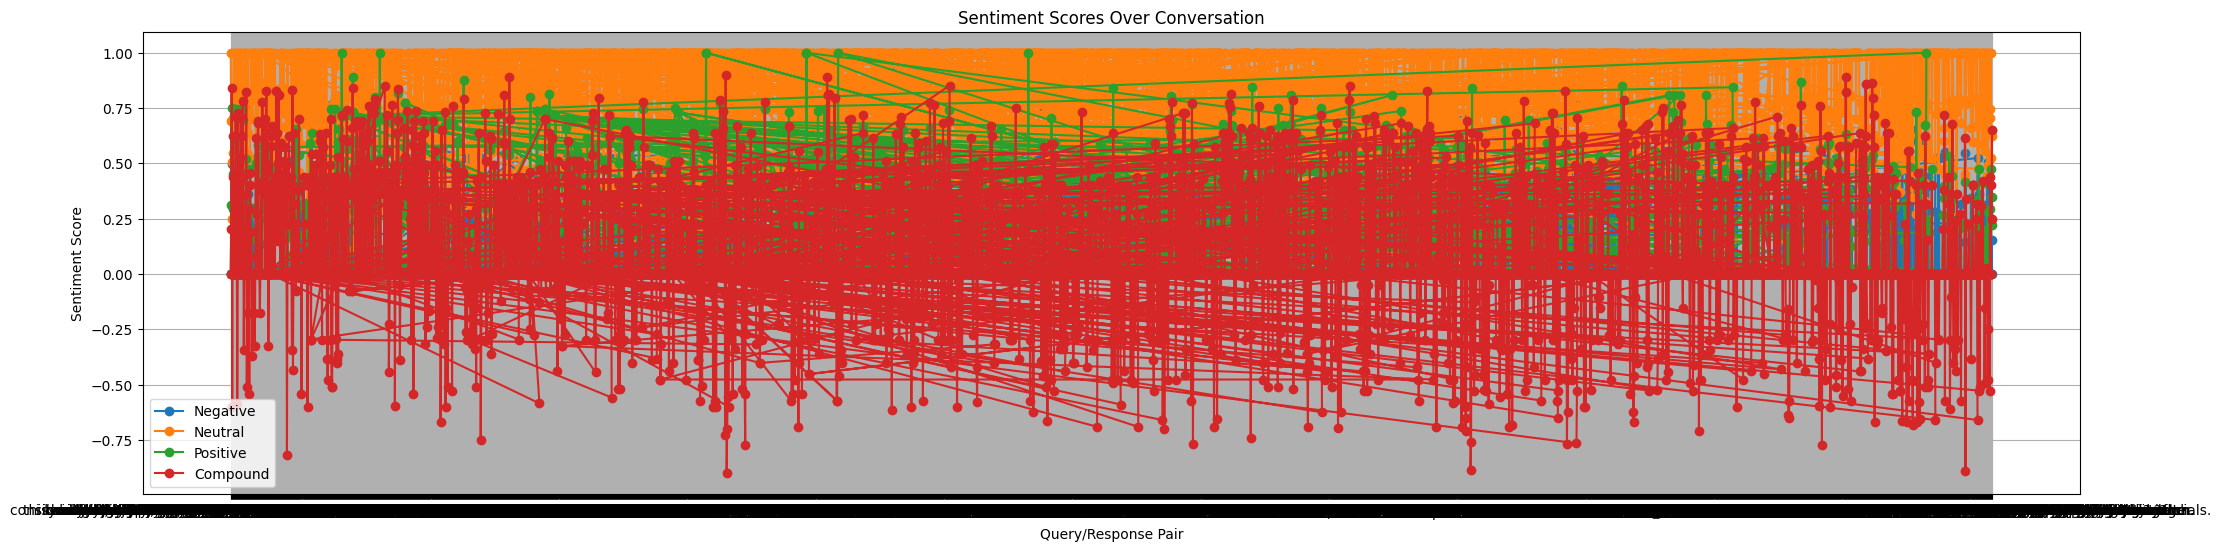

In [10]:
plt.figure(figsize=(25, 6))
plt.plot(df['Query'], df['neg'], label='Negative', marker='o')
plt.plot(df['Query'], df['neu'], label='Neutral', marker='o')
plt.plot(df['Query'], df['pos'], label='Positive', marker='o')
plt.plot(df['Query'], df['compound'], label='Compound', marker='o')
plt.xlabel('Query/Response Pair')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores Over Conversation')
plt.legend()
plt.grid(True)
plt.show()

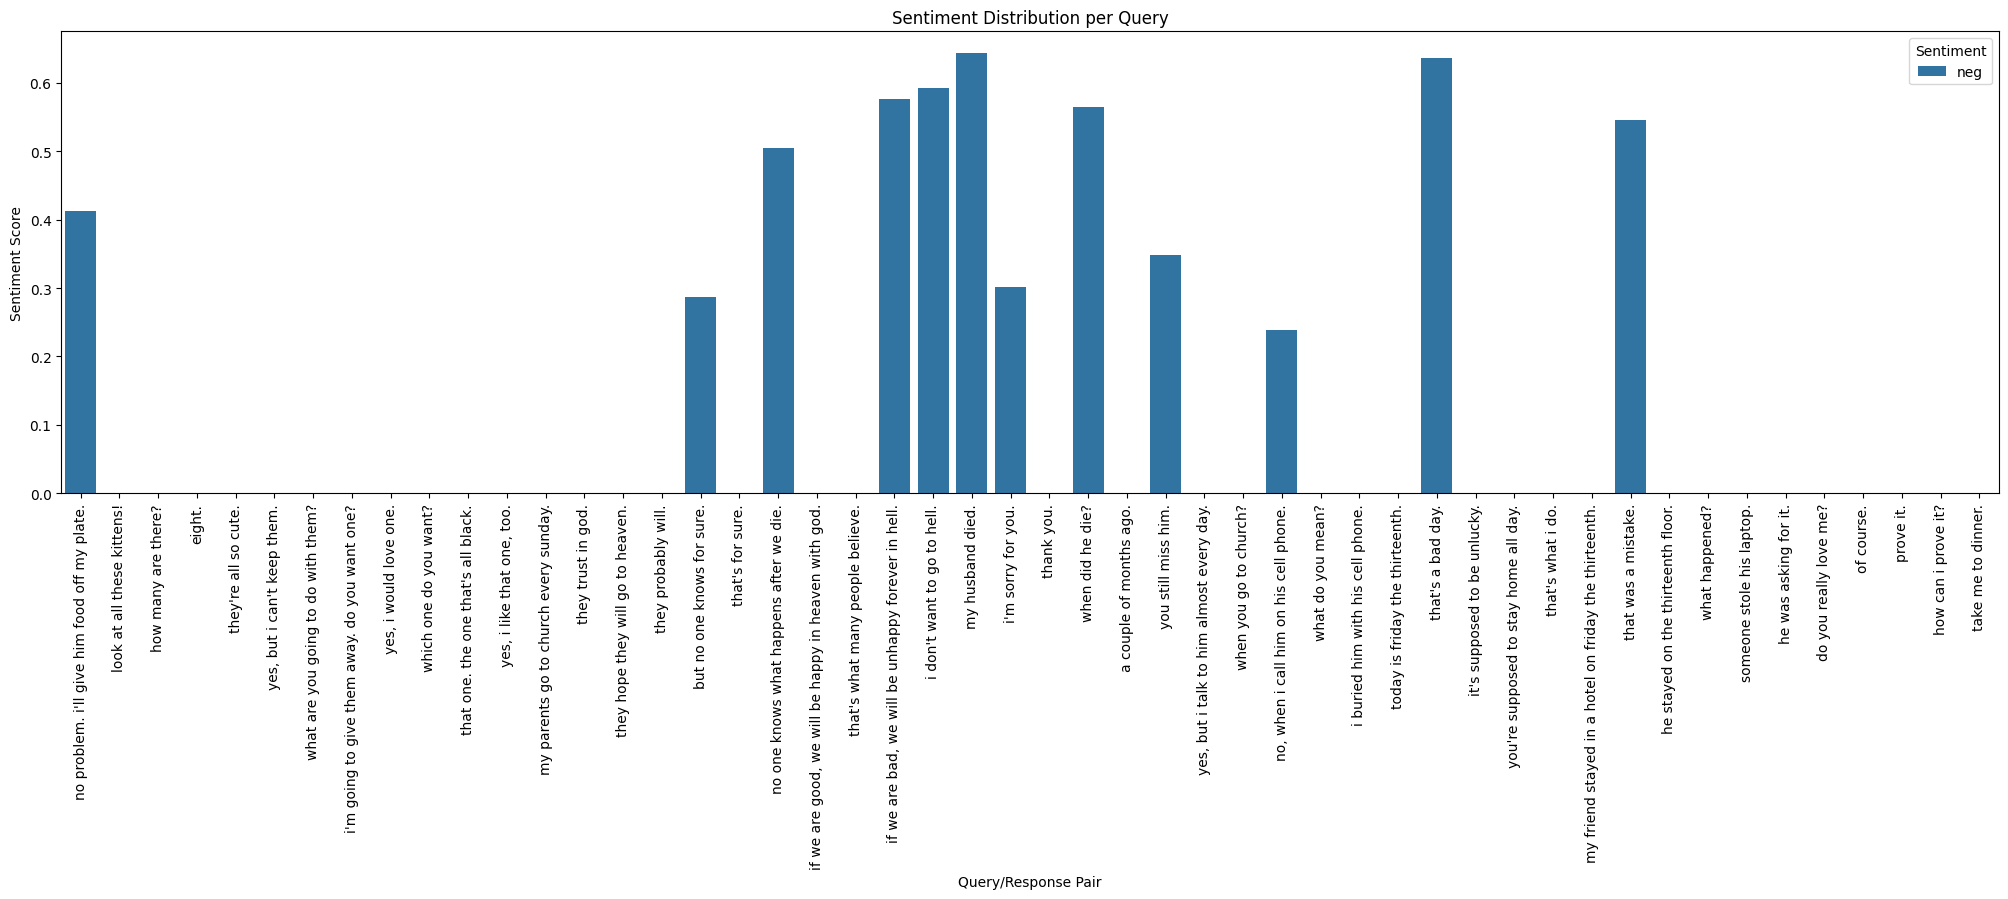

In [11]:
df_melted = df.melt(id_vars='Query', value_vars=['neg', 'neu', 'pos'], var_name='Sentiment', value_name='Score')

plt.figure(figsize=(25, 6))
sns.barplot(x='Query', y='Score', hue='Sentiment', data=df_melted[1000: 1050], dodge=False)
plt.xlabel('Query/Response Pair')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Distribution per Query')
plt.xticks(rotation=90)
plt.show()

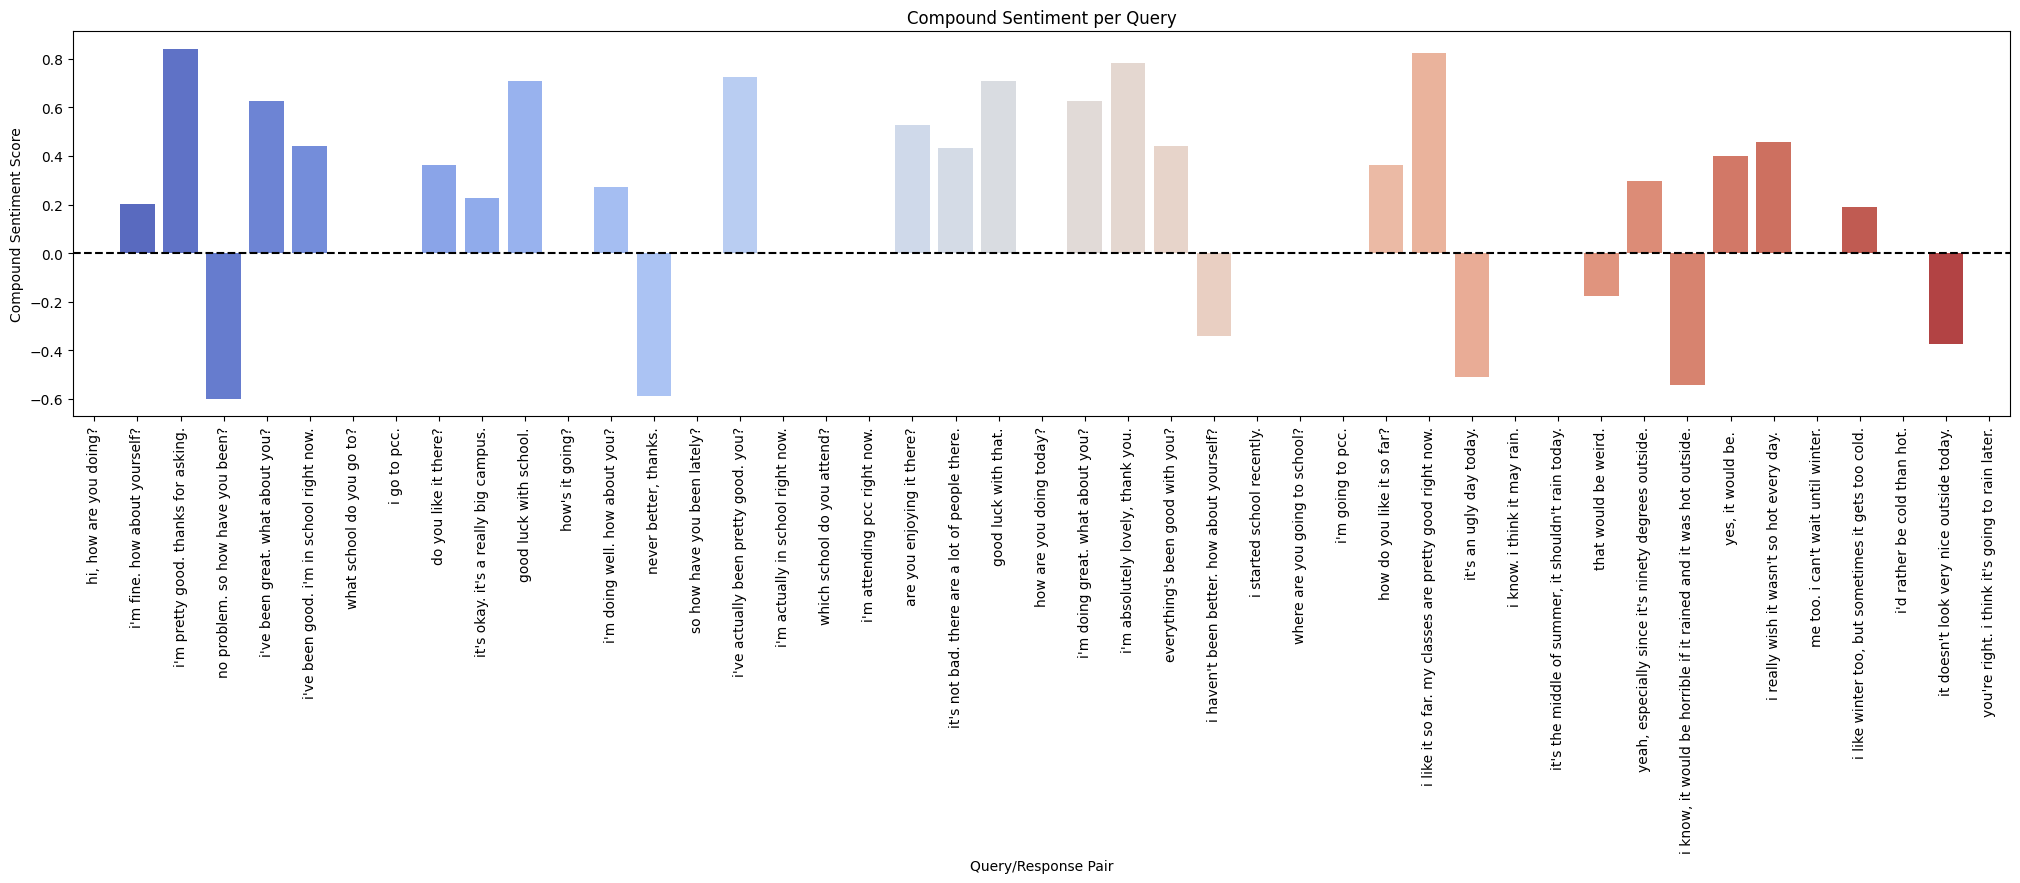

In [12]:
plt.figure(figsize=(25, 5))
sns.barplot(x='Query', y='compound', data=df[: 45], palette='coolwarm')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Query/Response Pair')
plt.ylabel('Compound Sentiment Score')
plt.title('Compound Sentiment per Query')
plt.xticks(rotation=90)
plt.show()

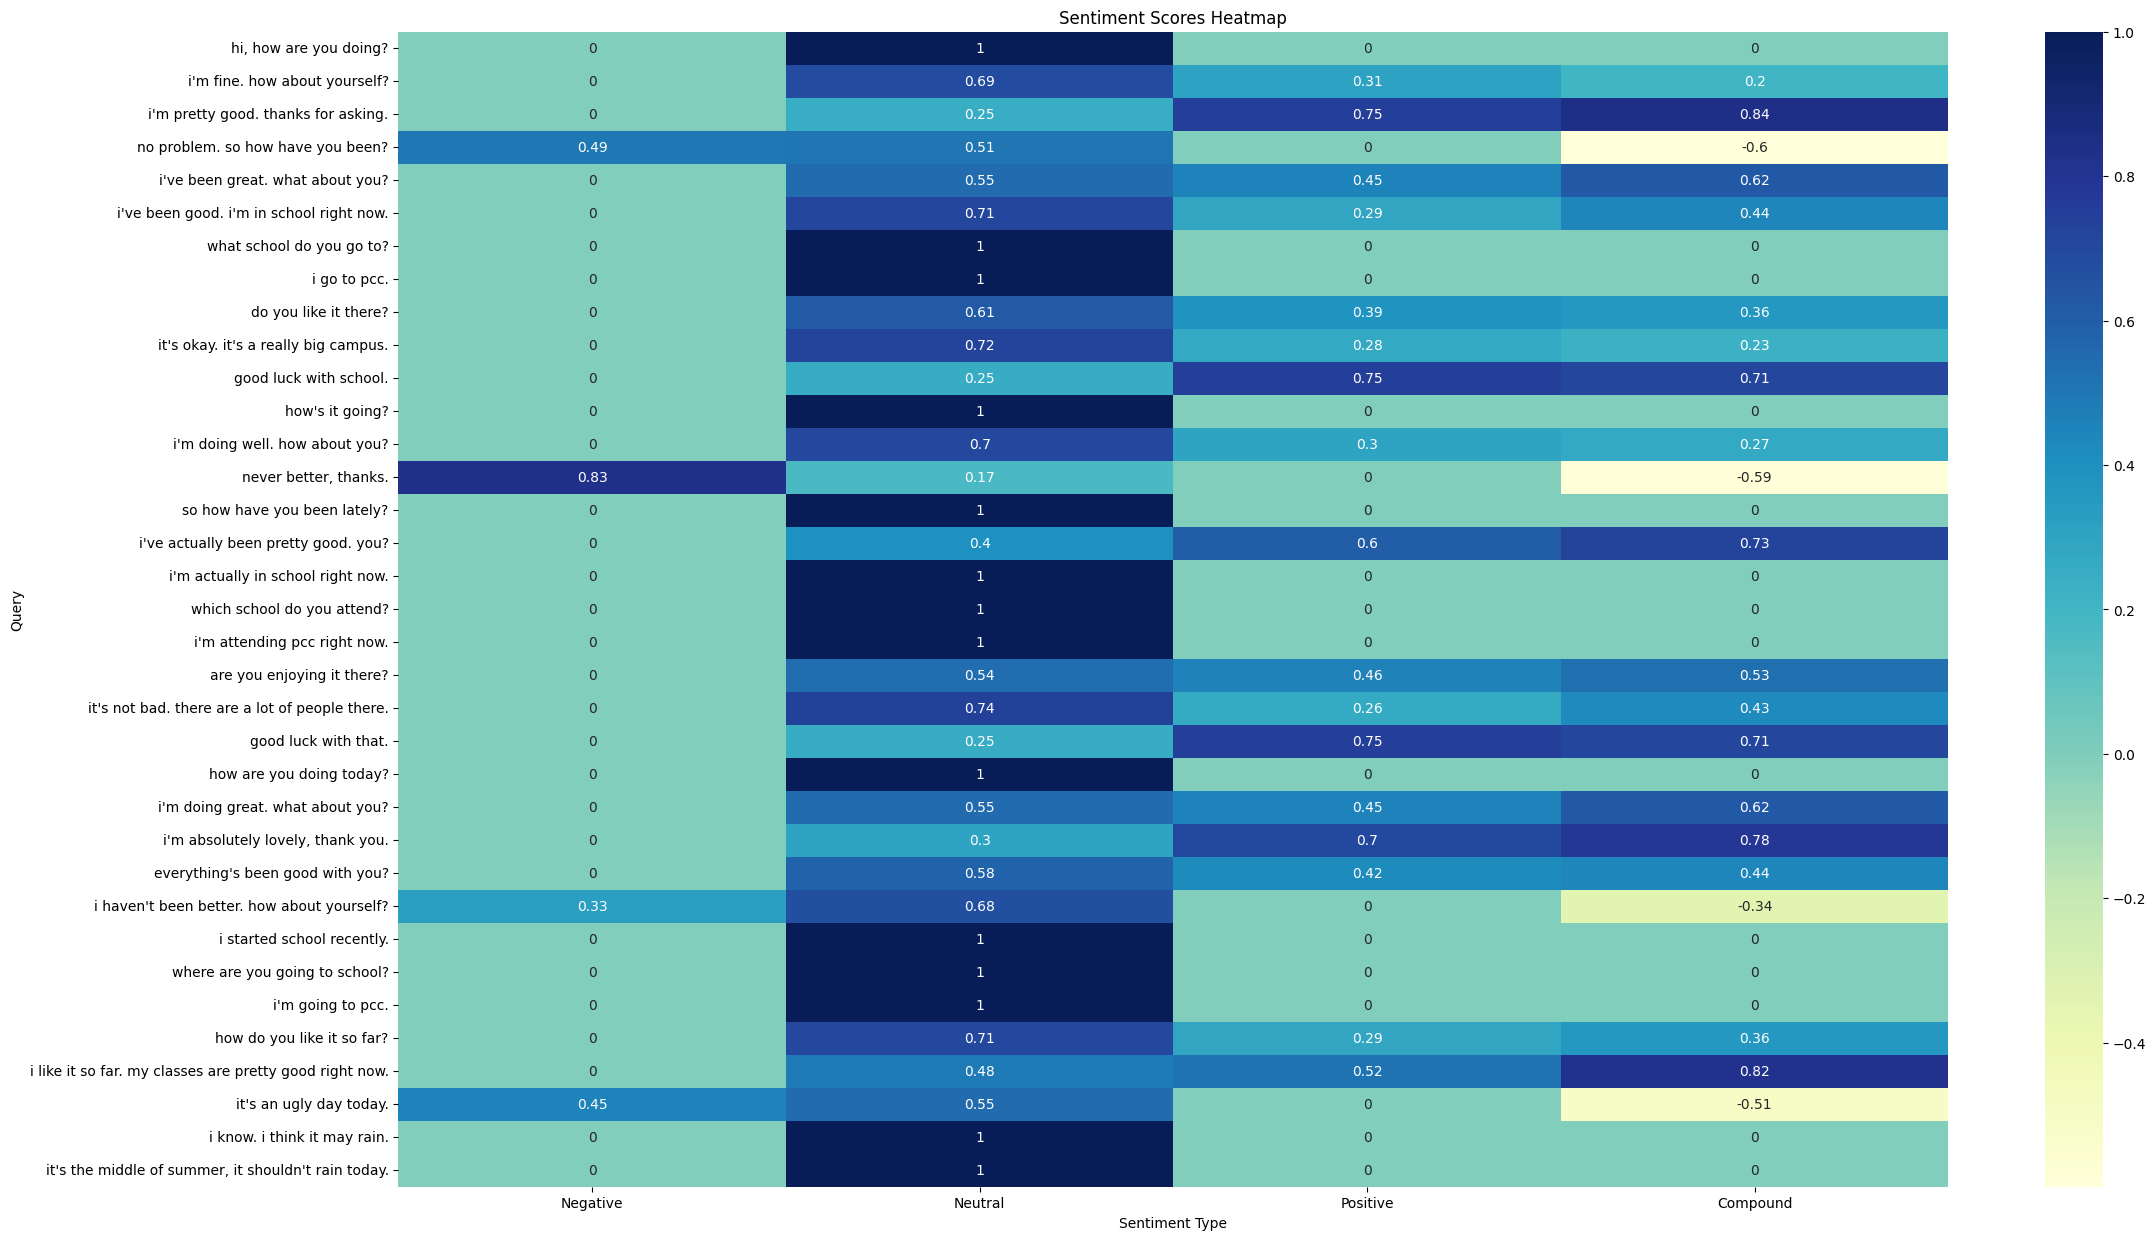

In [13]:
plt.figure(figsize=(25, 15))
sns.heatmap(df[['neg', 'neu', 'pos', 'compound']][:35],annot=True,cmap='YlGnBu',xticklabels=['Negative', 'Neutral', 'Positive', 'Compound'],
    yticklabels=df['Query'][:35])
plt.title('Sentiment Scores Heatmap')
plt.xlabel('Sentiment Type')
plt.ylabel('Query')
plt.show()

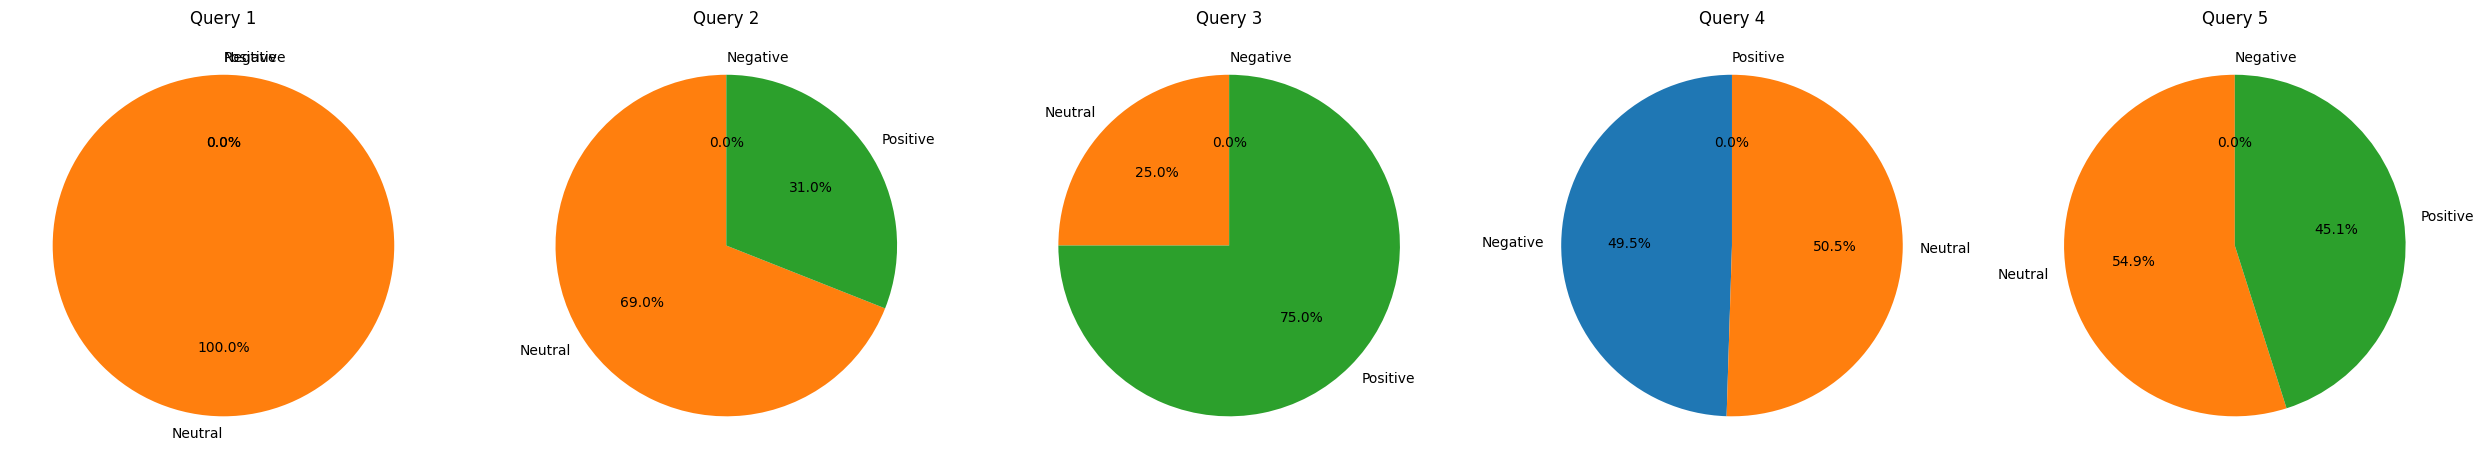

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(25, 15))
labels = ['Negative', 'Neutral', 'Positive']

for i, (index, row) in enumerate(df.head(5).iterrows()):
    scores = [row['neg'], row['neu'], row['pos']]
    axes[i].pie(scores, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Query {i+1}')

plt.tight_layout()
plt.show()


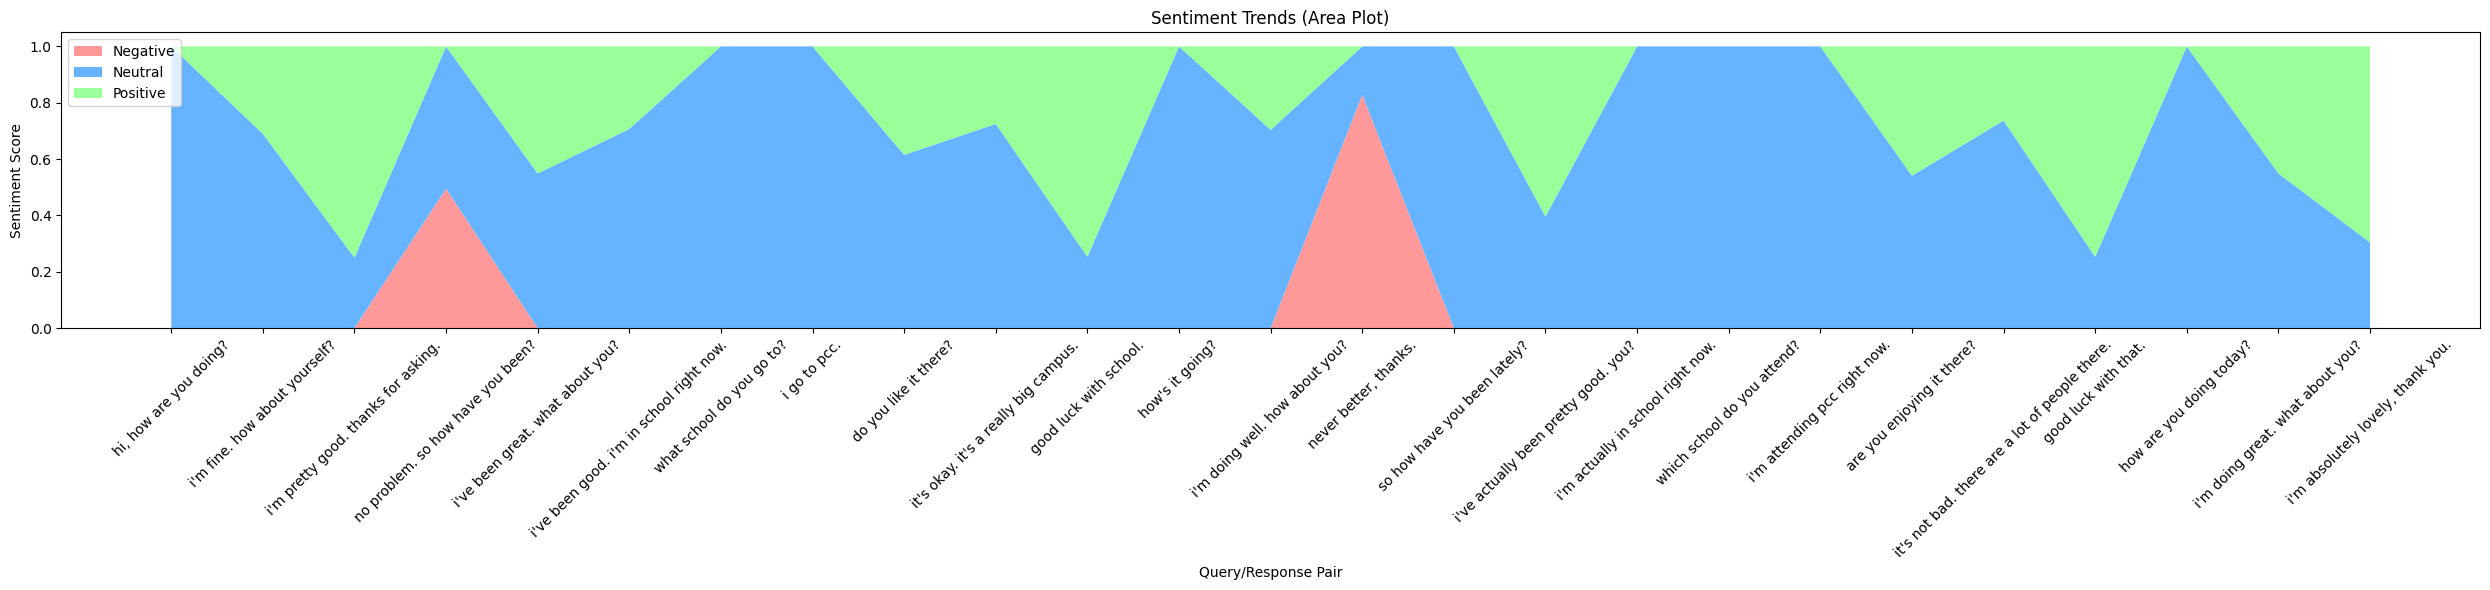

In [15]:
plt.figure(figsize=(25, 6))
plt.stackplot(
    df['Query'][:25],
    df['neg'][:25],
    df['neu'][:25],
    df['pos'][:25],
    labels=['Negative', 'Neutral', 'Positive'],
    colors=['#ff9999', '#66b3ff', '#99ff99']
)
plt.xlabel('Query/Response Pair')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Trends (Area Plot)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

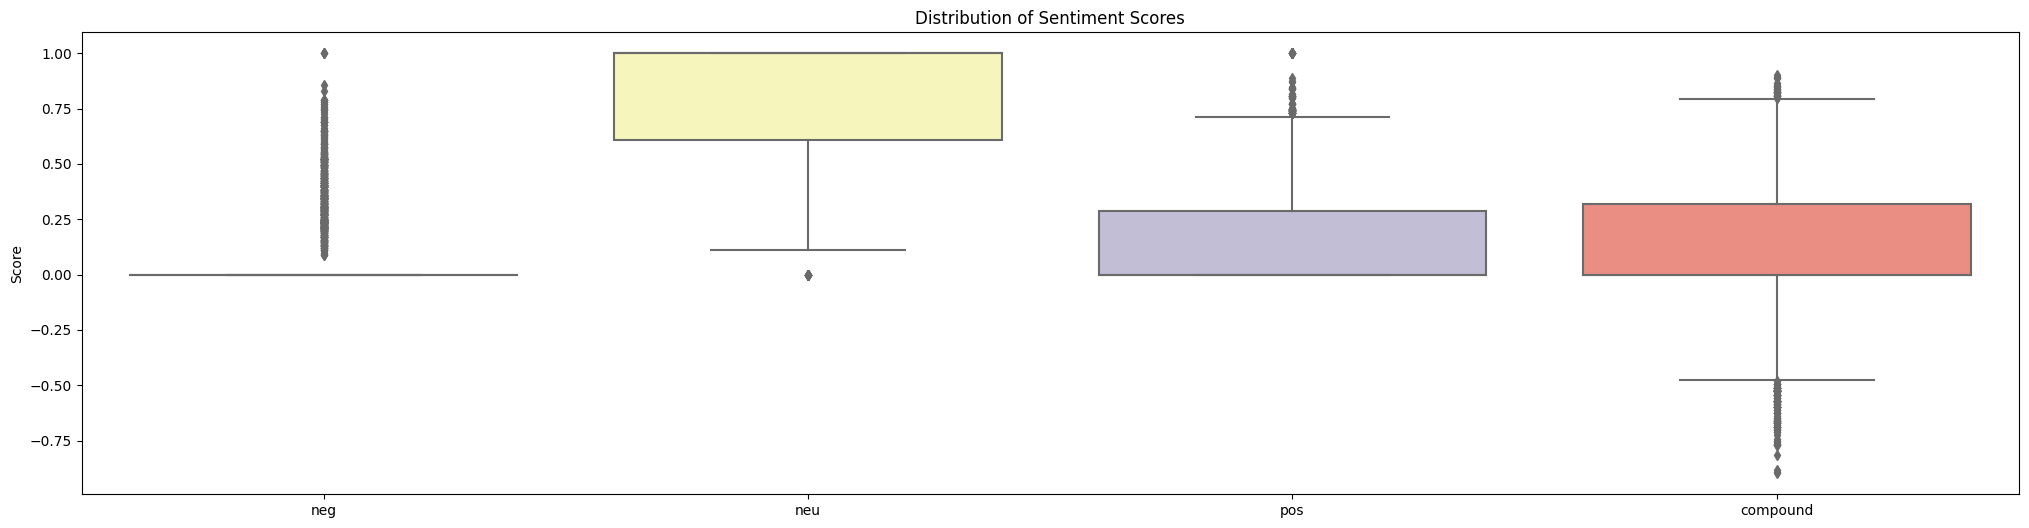

In [16]:
plt.figure(figsize=(25, 6))
sns.boxplot(data=df[['neg', 'neu', 'pos', 'compound']], palette='Set3')
plt.title('Distribution of Sentiment Scores')
plt.ylabel('Score')
plt.show()

In [26]:
import plotly.graph_objects as go
categories = ['Negative', 'Neutral', 'Positive']
fig = go.Figure()
for i in df['Query']:
    scores = df.loc[df['Query'] == i, ['neg', 'neu', 'pos']].values[0]
    fig.add_trace(go.Scatterpolar(r=scores, theta=categories, fill='toself', name=f'Query {i}'))
fig.update_layout(polar=dict(radialaxis=dict(visible=True)), showlegend=True, title='Sentiment Profiles')
fig.show()

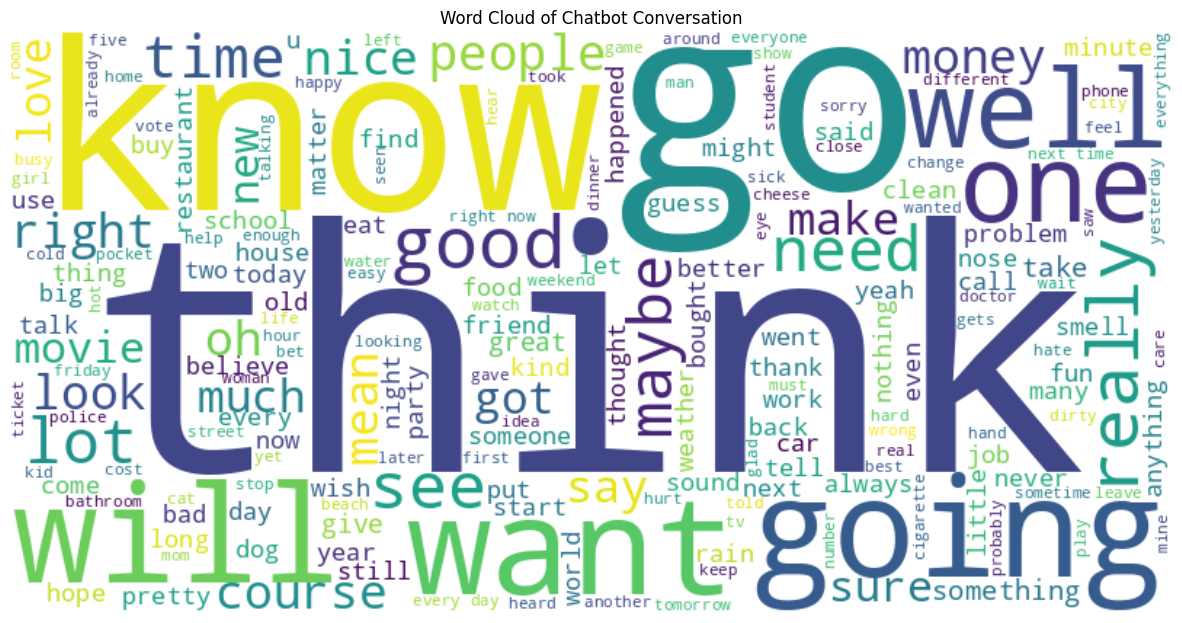

In [18]:
from wordcloud import WordCloud, STOPWORDS


# Use default stopwords and add custom ones if needed
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["please", "okay", "yes", "no", "hi", "hello", "thanks"])  # Add more if needed

text = " ".join([q + " " + r for q, r in zip(df['Query'].astype(str), df['Response'])])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=custom_stopwords
).generate(text)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Chatbot Conversation')
plt.show()


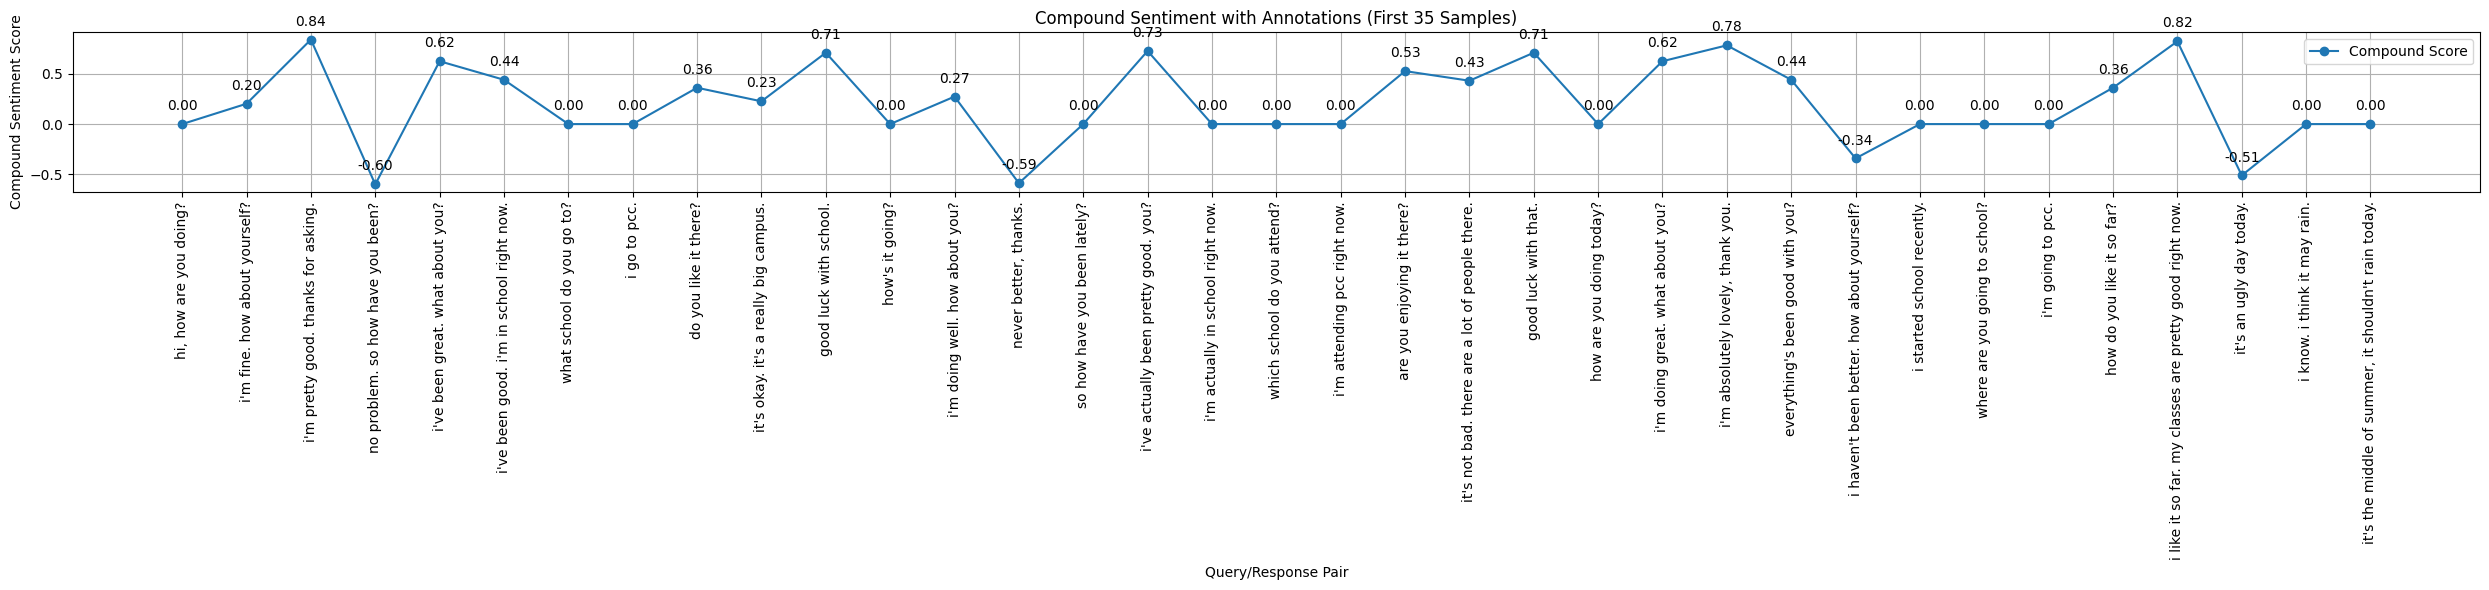

In [19]:
plt.figure(figsize=(25, 6))
plt.plot(df['Query'][:35], df['compound'][:35], marker='o', label='Compound Score')

for i in range(35):
    plt.annotate(
        f"{df['compound'][i]:.2f}",
        (df['Query'][i], df['compound'][i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )

plt.xlabel('Query/Response Pair')
plt.ylabel('Compound Sentiment Score')
plt.title('Compound Sentiment with Annotations (First 35 Samples)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [20]:
def clean_text(text):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', ' ').strip()
    text = text.encode("ascii", "ignore").decode()
    text = re.sub(r'\b\w*\d\w*\b', '', text)      # remove alphanumeric words (words with letters+digits)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)    # remove all special characters except spaces and alphanumeric
    text = re.sub(r'\s+', ' ', text).strip()      # remove extra spaces
    return text if text else ""

df['Query'] = df['Query'].apply(clean_text)
df['Response'] = df['Response'].apply(clean_text)

In [21]:
df.head()

,Query,Response,neg,neu,pos,compound
0,hi how are you doing,im fine how about yourself,0.000,1.000,0.000,0.0000
1,im fine how about yourself,im pretty good thanks for asking,0.000,0.690,0.310,0.2023
2,im pretty good thanks for asking,no problem so how have you been,0.000,0.250,0.750,0.8402
3,no problem so how have you been,ive been great what about you,0.495,0.505,0.000,-0.5994
4,ive been great what about you,ive been good im in school right now,0.000,0.549,0.451,0.6249


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from tabulate import tabulate
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
analyzer = SentimentIntensityAnalyzer()

model = SentenceTransformer('all-MiniLM-L6-v2')
query_embeddings = model.encode(df['Query'].tolist())


offensive_patterns = [r'\b(fuck|shit|damn|bitch|asshole|idiot|stupid|fool|dumb|cunt|nigger|retard|bastard|whore)\w*\b',r'\b(hate|kill|die|fag|slut)\b']

def is_offensive(text):
    """Check if text contains offensive words."""
    return any(re.search(pattern, text.lower(), re.IGNORECASE) for pattern in offensive_patterns)

def get_neutral_response():
   
    neutral_idx = df['compound'].abs().argmin()
    return {'response': df['Response'][neutral_idx],'pos': df['pos'][neutral_idx],'neg': df['neg'][neutral_idx],'neu': df['neu'][neutral_idx],'compound': df['compound'][neutral_idx]}

2025-08-05 16:00:43.962710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754409643.997208     587 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754409644.005798     587 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Batches:   0%|          | 0/117 [00:00<?, ?it/s]

In [23]:
def chatbot(query, confidence_threshold=0.5):
    global df, query_embeddings
    
    # Handle invalid queries
    if not isinstance(query, str) or not query.strip():
        neutral = get_neutral_response()
        sentiment = analyzer.polarity_scores(query or "invalid")
        return {
            'match': query,
            'response': neutral['response'],
            'score': np.min(cosine_similarity(query_embeddings, query_embeddings).flatten()) / 2,
            'pos': sentiment['pos'],
            'neg': sentiment['neg'],
            'neu': sentiment['neu'],
            'compound': sentiment['compound']
        }
    
    processed_query = query.lower().strip()
    
    # Handle offensive content
    if is_offensive(processed_query):
        neutral = get_neutral_response()
        sentiment = analyzer.polarity_scores(processed_query)
        return {
            'match': query,
            'response': neutral['response'],
            'score': np.min(cosine_similarity(query_embeddings, query_embeddings).flatten()) / 2,
            'pos': sentiment['pos'],
            'neg': sentiment['neg'],
            'neu': sentiment['neu'],
            'compound': sentiment['compound']
        }
    
    # Compute similarity
    query_embedding = model.encode([processed_query])[0]
    similarities = cosine_similarity([query_embedding], query_embeddings)[0]
    max_similarity = np.max(similarities)
    best_match_idx = np.argmax(similarities)
    
    # Return dataset-driven response for matched queries
    match = df.iloc[best_match_idx]
    response = {
        'match': match['Query'],
        'response': match['Response'],
        'score': max_similarity,
        'pos': match['pos'],
        'neg': match['neg'],
        'neu': match['neu'],
        'compound': match['compound']
    }
    
    # Handle low-confidence matches
    if max_similarity < confidence_threshold:
        neutral = get_neutral_response()
        user_response = input(f"Unknown query: '{query}'. Teach me a response (or 'skip'): ")
        if user_response.lower() != 'skip':
            if is_offensive(user_response):
                user_response = input("Inappropriate response. Try another (or 'skip'): ")
                if user_response.lower() == 'skip':
                    return {
                        'match': query,
                        'response': neutral['response'],
                        'score': np.min(similarities) / 2,
                        'pos': neutral['pos'],
                        'neg': neutral['neg'],
                        'neu': neutral['neu'],
                        'compound': neutral['compound']
                    }
            sentiment = analyzer.polarity_scores(user_response)
            new_entry = {
                'Query': query,
                'Response': user_response,
                'neg': sentiment['neg'],
                'neu': sentiment['neu'],
                'pos': sentiment['pos'],
                'compound': sentiment['compound']
            }
            df = pd.concat([df, pd.DataFrame([new_entry])], ignore_index=True)
            query_embeddings = model.encode(df['Query'].tolist())
            response = {
                'match': query,
                'response': user_response,
                'score': max(similarities) if similarities.size > 0 else 0.5,
                'pos': sentiment['pos'],
                'neg': sentiment['neg'],
                'neu': sentiment['neu'],
                'compound': sentiment['compound']
            }
    
    return response

In [24]:
print("Welcome to the Chatbot! Type 'exit' to quit.")
conversation_history = []

while True:
    query = input("User: ")
    if query.lower() == 'exit':
        break
    
    response = chatbot(query)
    conversation_history.append(response)
    
    print("="*80)
    print(f"logs:\n Match Question: {response['match']!r}\n Confidence Score: {response['score']*100:.2f}\n "
          f"Positive Score: {response['pos']}\n Negative Score: {response['neg']}\n Neutral Score: {response['neu']}\n "
          f"Compound Score: {response['compound']}")
    print("="*80)
    print(f"Bot: {response['response']}")

Welcome to the Chatbot! Type 'exit' to quit.


User:  hello


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logs:
 Match Question: 'hi how are you doing'
 Confidence Score: 58.22
 Positive Score: 0.0
 Negative Score: 0.0
 Neutral Score: 1.0
 Compound Score: 0.0
Bot: im fine how about yourself


User:  i will talk to you tomorrow bitch


logs:
 Match Question: 'i will talk to you tomorrow bitch'
 Confidence Score: -11.82
 Positive Score: 0.0
 Negative Score: 0.432
 Neutral Score: 0.568
 Compound Score: -0.5859
Bot: im fine how about yourself


User:  i will talk to you tomorror


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Unknown query: 'i will talk to you tomorror'. Teach me a response (or 'skip'):  skip


logs:
 Match Question: 'ill talk to you later'
 Confidence Score: 49.28
 Positive Score: 0.0
 Negative Score: 0.0
 Neutral Score: 1.0
 Compound Score: 0.0
Bot: whats the rush


User:  i will talk to you tomorrow


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logs:
 Match Question: 'ill talk to you later'
 Confidence Score: 70.48
 Positive Score: 0.0
 Negative Score: 0.0
 Neutral Score: 1.0
 Compound Score: 0.0
Bot: whats the rush


User:  i am busy nowadays


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logs:
 Match Question: 'lately ive been quite busy'
 Confidence Score: 74.33
 Positive Score: 0.0
 Negative Score: 0.0
 Neutral Score: 1.0
 Compound Score: 0.0
Bot: tell me what youve been up to


User:  i am planning to destroy the world


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logs:
 Match Question: 'what is this world coming to'
 Confidence Score: 53.21
 Positive Score: 0.0
 Negative Score: 0.0
 Neutral Score: 1.0
 Compound Score: 0.0
Bot: who knows maybe soon well have pink bananas


User:  i hate pink


logs:
 Match Question: 'i hate pink'
 Confidence Score: -11.82
 Positive Score: 0.0
 Negative Score: 0.787
 Neutral Score: 0.213
 Compound Score: -0.5719
Bot: im fine how about yourself


User:  i don't like pink


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logs:
 Match Question: 'no its dark pink'
 Confidence Score: 55.77
 Positive Score: 0.0
 Negative Score: 0.454
 Neutral Score: 0.546
 Compound Score: -0.3595
Bot: are you sure i never heard of such a thing


User:  why whats wrong with it??


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logs:
 Match Question: 'whats wrong with it'
 Confidence Score: 75.57
 Positive Score: 0.0
 Negative Score: 0.508
 Neutral Score: 0.492
 Compound Score: -0.4767
Bot: it aches most of the time


User:  whats that??


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logs:
 Match Question: 'whats that'
 Confidence Score: 75.55
 Positive Score: 0.0
 Negative Score: 0.0
 Neutral Score: 1.0
 Compound Score: 0.0
Bot: people talk about current events


User:  tell me about tv series name dark


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Unknown query: 'tell me about tv series name dark'. Teach me a response (or 'skip'):  Dark — Overview Genre: Science Fiction, Thriller, Mystery, Drama  Country: Germany  Language: German (with subtitles/dubbing available)  Platform: Originally on Netflix  Seasons: 3  Episodes: 26 (across 3 seasons)


Batches:   0%|          | 0/117 [00:00<?, ?it/s]

logs:
 Match Question: 'tell me about tv series name dark'
 Confidence Score: 40.85
 Positive Score: 0.057
 Negative Score: 0.0
 Neutral Score: 0.943
 Compound Score: 0.1027
Bot: Dark — Overview Genre: Science Fiction, Thriller, Mystery, Drama  Country: Germany  Language: German (with subtitles/dubbing available)  Platform: Originally on Netflix  Seasons: 3  Episodes: 26 (across 3 seasons)


User:  tell me about dark


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logs:
 Match Question: 'tell me about tv series name dark'
 Confidence Score: 67.71
 Positive Score: 0.057
 Negative Score: 0.0
 Neutral Score: 0.943
 Compound Score: 0.1027
Bot: Dark — Overview Genre: Science Fiction, Thriller, Mystery, Drama  Country: Germany  Language: German (with subtitles/dubbing available)  Platform: Originally on Netflix  Seasons: 3  Episodes: 26 (across 3 seasons)


User:  tell me about who is the best cricketer all time??


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Unknown query: 'tell me about who is the best cricketer all time??'. Teach me a response (or 'skip'):  1. Sir Donald Bradman (Australia) Often regarded as the greatest batsman ever.  Test batting average: 99.94 (unmatched record).  Played mainly in the 1930s-1940s.  Renowned for his incredible consistency and domination.


Batches:   0%|          | 0/117 [00:00<?, ?it/s]

logs:
 Match Question: 'tell me about who is the best cricketer all time??'
 Confidence Score: 49.71
 Positive Score: 0.19
 Negative Score: 0.034
 Neutral Score: 0.776
 Compound Score: 0.7506
Bot: 1. Sir Donald Bradman (Australia) Often regarded as the greatest batsman ever.  Test batting average: 99.94 (unmatched record).  Played mainly in the 1930s-1940s.  Renowned for his incredible consistency and domination.


User:  hi babu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Unknown query: 'hi babu'. Teach me a response (or 'skip'):  hello babu


Batches:   0%|          | 0/117 [00:00<?, ?it/s]

logs:
 Match Question: 'hi babu'
 Confidence Score: 40.55
 Positive Score: 0.0
 Negative Score: 0.0
 Neutral Score: 1.0
 Compound Score: 0.0
Bot: hello babu


User:  tell me about who is the best crickter of all time??


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

logs:
 Match Question: 'tell me about who is the best cricketer all time??'
 Confidence Score: 59.45
 Positive Score: 0.19
 Negative Score: 0.034
 Neutral Score: 0.776
 Compound Score: 0.7506
Bot: 1. Sir Donald Bradman (Australia) Often regarded as the greatest batsman ever.  Test batting average: 99.94 (unmatched record).  Played mainly in the 1930s-1940s.  Renowned for his incredible consistency and domination.


User:  nice brother


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Unknown query: 'nice brother'. Teach me a response (or 'skip'):  partner of crime


Batches:   0%|          | 0/117 [00:00<?, ?it/s]

logs:
 Match Question: 'nice brother'
 Confidence Score: 49.71
 Positive Score: 0.0
 Negative Score: 0.636
 Neutral Score: 0.364
 Compound Score: -0.5423
Bot: partner of crime


User:  exit
